In [7]:
import os
import pickle

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
pd.options.display.max_columns = 100
%matplotlib inline

# Economic District Model
This model will use a basic economic profile of districts/states (industry composition from the US Census' County Business Pattern dataset) to predict voting patterns.
## Feature Construction

In [18]:
# load and format district economic cosine similarity into dictionary
# dict[session]['id1', 'id2']
path = '../data/districts/cbp_preprocessed/'
dict_cosines = {}
for file in os.listdir(path):
    if not file.startswith('combined'):
        continue
    ind = ['id_d1', 'id_d2']
    df = pd.read_csv(path + file, usecols=ind + ['cosine'], index_col=ind)
    year = int(file.split("_")[0][-3:])
    dict_cosines[year] = df.to_dict(orient = 'index')

# Load plain district economic info
i = 0
for file in os.listdir(path):
    if not file.endswith('composition.csv'):
        continue
    df = pd.read_csv(path + file)
    if i == 0:
        df_comp = df
        i += 1
    else:
        df_comp = pd.concat([df_comp, df])
df_comp.drop(['district', 'state_abbr'], axis = 1, inplace = True)
df_comp.rename(columns={'id': 'member_id', 'session': 'congress'}, inplace = True)

# get member info
columns = ['id', 'short_title', 'state', 'session']
df_members = pd.read_csv('../data/propublica/members_all.csv', encoding = 'latin1', usecols=columns)
df_members.drop_duplicates(subset = ['id', 'session'], inplace = True)
dict_members = df_members.set_index(['id', 'session']).to_dict(orient = 'index')

# grab member ids of successful amendments.
df_amendments = pd.read_csv('../data/model/vote_history/amendment_votes_raw.csv')
df_amendments = df_amendments[df_amendments.result.str.contains('Agree')]
df_amendments = pd.DataFrame(df_amendments.groupby('bill_id').member_id.agg(lambda x: list(x)))
df_amendments.rename(columns={0: 'amendment_ids'}, inplace = True)
df_amendments.reset_index(inplace = True)

# pull in bills
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.dropna(subset = ['sponsor_id'], inplace = True)
df_bills = pd.merge(df_bills, df_amendments, how = 'left', on = 'bill_id')
def fix_eval(row):
    """Combination of different API pulls from different people resulted in lists being inconsistenly stored
        Also append the sponsor id and ids of members who had a successful ammendment
    """
    try:
        new = eval(row.cosponsor)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        new = row.cosponsor.replace('[', "")
        new = new.replace(']', "")
        new = new.split(', ')
    except:
        if type(row.cosponsor) == float:
            new = []
        else:
            new = row.cosponsor
    new.append(row.sponsor_id)
    if type(row.amendment_ids) == list:
        for a_id in row.amendment_ids:
            new.append(a_id)
    return set(new)
df_bills['cosponsor_ids'] = df_bills.apply(fix_eval, axis = 1)
df_bills['n_cos'] = df_bills.cosponsor_ids.apply(lambda x: len(x))

# dummy code committees
def fix_coms(row):
    """eval committee lists"""
    try:
        new = eval(row)
        if type(new[0]) == list:
            new = new[0]
    except NameError:
        row = row.replace('[', "")
        row = row.replace(']', "")
        new = row.split(', ')
    except:
        new = row
    return new

df_bills['com_codes_fuzzy2'] = df_bills.com_codes_fuzzy2.apply(fix_coms)
df_bills.rename(columns={'com_codes_fuzzy2': 'committee_codes2'}, inplace = True)
committee_dummies = pd.get_dummies(df_bills.committee_codes2.apply(pd.Series).stack()).sum(level=0)
committee_dummies.columns = ["com_" + x for x in committee_dummies.columns]
df_bills = pd.concat([df_bills, committee_dummies], axis = 1)
columns = ['bill_id', 'cosponsor_ids', 'n_cos']
columns += [x for x in df_bills.columns if x.startswith('com_') and len(x) == 8]
df_bills = df_bills[columns]

# votes file
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_bills, on = 'bill_id', how = 'left')
df_votes.dropna(subset = ['n_cos'], inplace = True)
df_votes.reset_index(inplace = True, drop = True)
df_votes = pd.merge(df_votes, df_members, 
                    how = 'left', 
                    left_on=['member_id', 'congress'], 
                    right_on=['id', 'session'])
df_votes.dropna(inplace = True)
df_votes = df_votes[df_votes.session_y >= 113]
df_votes.reset_index(inplace = True, drop = True)

# get central tendency stats for cosine sims between member and cosponsors
stats = []
for i, m1 in df_votes.iterrows():
    cosines = []
    for m2 in m1.cosponsor_ids:
        if m2 == m1.id:
            continue
        try:
            cosine = dict_cosines[m1.congress][(m1.member_id, m2)]['cosine']
            cosines.append(cosine)
        except:
            continue
    cosines = pd.Series(cosines).describe()
    cosines.index = ["cosine_" + x for x in cosines.index]
    cosines.fillna(-1, inplace = True)
    cosines = cosines.to_dict()
    stats.append(cosines)
stats = pd.DataFrame(stats)
stats = stats[stats.cosine_count > 0]
df_votes = pd.concat([df_votes, stats], axis = 1)
df_votes.dropna(subset = ['cosine_max'], inplace = True)
df_votes = pd.merge(df_votes, df_comp, how = 'left', on = ['member_id', 'congress'])

# export feature set
columns = ['full_set_id']
columns += stats.columns.tolist()
columns += df_comp.columns.tolist()
columns = columns[:-2]
columns += [x for x in df_votes.columns if x.startswith('com_')]
df_votes = df_votes[columns]
df_votes.dropna(inplace = True)
df_votes.to_csv('../data/model/districts/econ_features.csv', index = False)

## Model

In [94]:
df_votes.head(1)

,full_set_id,cosine_25%,cosine_50%,cosine_75%,cosine_count,cosine_max,cosine_mean,cosine_min,cosine_std,11----,21----,22----,23----,31----,42----,44----,48----,51----,52----,53----,54----,55----,56----,61----,62----,71----,72----,81----,99----,com_HLIG,com_HSAG,com_HSAP,com_HSAS,com_HSBA,com_HSBU,com_HSED,com_HSFA,com_HSGO,com_HSHA,com_HSHM,com_HSIF,com_HSIG,com_HSII,com_HSJU,com_HSPW,com_HSRU,com_HSSM,com_HSSO,com_HSSY,com_HSVR,com_HSWM,com_JCSE,com_SLIA,com_SLIN,com_SSAF,com_SSAP,com_SSAS,com_SSBK,com_SSBU,com_SSCM,com_SSEG,com_SSEV,com_SSFI,com_SSFR,com_SSGA,com_SSHR,com_SSJU,com_SSRA,com_SSSB,com_SSVA
0,1688860,0.945801,0.953529,0.96226,8.0,0.985202,0.957149,0.940824,0.015703,0.031754,0.284496,0.442741,3.787158,14.190113,4.997937,12.364885,3.52254,1.917459,5.35419,1.384426,5.172753,3.241567,6.661835,2.679327,18.101194,1.400565,10.02525,4.432042,0.007769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['cosine_25%', 'com_HLIG'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [96]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9627    0.9631    0.9629    134478
          1     0.0371    0.0367    0.0369      5207

avg / total     0.9282    0.9286    0.9284    139685



In [97]:
features = [x for x in columns if x != 'full_set_id']
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


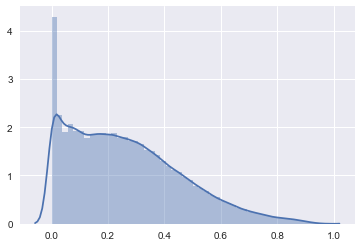

In [98]:
# distribution is normal?? Really weird for this dataset
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [105]:
thresh = .665
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

5607
             precision    recall  f1-score   support

          0     0.9730    0.9701    0.9716    134478
          1     0.2839    0.3057    0.2944      5207

avg / total     0.9474    0.9454    0.9463    139685



In [106]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/districts/econ_rfc.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'district_econ', predictors=features)